In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tools import networkHelpers as nh
from umap import UMAP
import scipy.stats as stats
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap

In [2]:
hgnc_mapper = nh.fetch_hgnc_mapper()

In [3]:
duncan = pd.read_excel('../data/mib-ms/Duncan2012-Fig2D-data.xlsx', sheet_name='Sheet1')
duncan.head()

,Kinase ID,Gene Symbol,Name,4 hrs AZD6244/DMSO,12 hrs AZD6244/DMSO,24 hrs AZD6244/DMSO
0,EPHA2,EPHA2,Ephrin type-A receptor 2 OS=Homo sapiens GN=EP...,0.879022,0.591562,0.401791
1,KS6A1,RPS6KA1,Ribosomal protein S6 kinase alpha-1 OS=Homo sa...,1.116863,1.148154,1.541700
2,ERK2,MAPK1,Mitogen-activated protein kinase 1 OS=Homo sap...,1.037528,1.000000,1.056818
3,KCC2G,CAMK2G,Calcium/calmodulin-dependent protein kinase ty...,1.318257,1.047129,3.133286
4,GSK3B,GSK3B,Glycogen synthase kinase-3 beta OS=Homo sapien...,0.981748,0.772681,1.247383


In [4]:
all_mibrna = pd.read_excel('../data/mib-ms/All_mibplusrnadata_autoscaled.xlsx', sheet_name='Sheet1', header=0, skiprows=0, index_col=0)
subtypes_all_mibrna = all_mibrna.iloc[0, :]
which_omic = all_mibrna.iloc[1, :]

all_mibrna = all_mibrna.loc[all_mibrna.index.tolist()[2:]]
rna_mibrna = all_mibrna[all_mibrna.columns[which_omic == 'rna']]
mib_mibrna = all_mibrna[all_mibrna.columns[which_omic != 'rna']]

mib_mibrna.head()

,SUM159.1,SUM159.2,MDA231.1,MDA231.2,SUM229neg.1,SUM229neg.2,HCC1806.1,HCC1806.2,MDA468.1,MDA468.2,...,HCC1954.1,HCC1954.2,MCF7.1,MCF7.2,T47D.1,T47D.2,HCC1428.1,HCC1428.2,ZR751.1,ZR751.2
AAK1,0.563173,0.620986,0.562031,0.426585,0.84158,0.602266,0.624378,0.633291,0.526394,0.469651,...,0.589088,0.559325,0.577343,0.650038,0.609829,0.610864,0.616032,0.384855,0.374681,0.751435
AAPK1,0.507465,0.577258,0.617139,0.583473,0.786363,0.550779,0.593335,0.688663,0.561773,0.574942,...,0.642642,0.633054,0.659526,0.724569,0.674675,0.689711,0.759279,0.564204,0.548872,0.799326
AAPK2,0.251648,0.477315,0.493465,0.418181,0.653195,0.422767,0.443998,0.656483,0.307084,0.317665,...,0.553135,0.567906,0.518407,0.660683,0.58118,0.596361,0.67794,0.4956,0.307634,0.697692
ABL1,0.109939,0.263185,0.436958,0.368187,0.500801,0.166916,0.179506,0.192641,-0.175774,0.272601,...,0.229982,0.226838,0.333653,0.453882,0.377198,0.286458,0.619932,0.241495,0.104607,0.492236
ABL2,0.123534,0.292926,0.460951,0.381616,0.516715,0.178025,0.216407,0.210545,-0.141703,0.277062,...,0.273476,0.27511,0.28847,0.425466,0.355888,0.28181,0.53327,0.303736,0.147329,0.541386


In [5]:
list(subtypes_all_mibrna)

['claudin',
 'claudin',
 'claudin',
 'basal',
 'basal',
 'basal',
 'her2',
 'her2',
 'her2',
 'basal/her2',
 'her2',
 'luminal',
 'luminal',
 'luminal',
 'luminal',
 'claudin',
 'claudin',
 'claudin',
 'claudin',
 'claudin',
 'claudin',
 'basal',
 'basal',
 'basal',
 'basal',
 'basal',
 'basal',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'her2',
 'basal/her2',
 'basal/her2',
 'luminal',
 'luminal',
 'luminal',
 'luminal',
 'luminal',
 'luminal',
 'luminal',
 'luminal']

In [6]:
list(mib_mibrna.columns)

['SUM159.1',
 'SUM159.2',
 'MDA231.1',
 'MDA231.2',
 'SUM229neg.1',
 'SUM229neg.2',
 'HCC1806.1',
 'HCC1806.2',
 'MDA468.1',
 'MDA468.2',
 'SUM229pos.1',
 'SUM229pos.2',
 'SKBR3.1',
 'SKBR3.2',
 'SKBR3.3',
 'BT474.1',
 'BT474.2',
 'BT474.3',
 'HCC1419.1',
 'HCC1419.2',
 'MDA361.1',
 'MDA361.2',
 'HCC1954.1',
 'HCC1954.2',
 'MCF7.1',
 'MCF7.2',
 'T47D.1',
 'T47D.2',
 'HCC1428.1',
 'HCC1428.2',
 'ZR751.1',
 'ZR751.2']

In [7]:
list(mib_mibrna.index)

['AAK1',
 'AAPK1',
 'AAPK2',
 'ABL1',
 'ABL2',
 'ACK1',
 'ACV1B',
 'ACVR1',
 'ADCK1',
 'ADK',
 'AGK',
 'AKT1',
 'AKT2',
 'AKT3',
 'ARAF',
 'AURKB',
 'AVR2A',
 'BCKD',
 'BMP2K',
 'BMPR2',
 'BMR1A',
 'BRAF',
 'BUB1',
 'CDK1',
 'CDK10',
 'CDK12',
 'CDK13',
 'CDK14',
 'CDK16',
 'CDK17',
 'CDK18',
 'CDK19',
 'CDK2',
 'CDK3',
 'CDK4',
 'CDK5',
 'CDK6',
 'CDK7',
 'CDK8',
 'CDK9',
 'CDKL5',
 'CHK1',
 'CHK2',
 'CHKA',
 'CHKB',
 'CLK1',
 'CLK2',
 'CLK3',
 'CLK4',
 'CSK',
 'CSK21',
 'CSK22',
 'CSK23',
 'DAPK3',
 'DCK',
 'DDR1',
 'DMPK',
 'DYR1A',
 'DYR1B',
 'E2AK1',
 'E2AK2',
 'E2AK4',
 'EGFR',
 'EPHA1',
 'EPHA2',
 'EPHA3',
 'EPHA4',
 'EPHA5',
 'EPHA7',
 'EPHB1',
 'EPHB2',
 'EPHB3',
 'EPHB4',
 'EPHB6',
 'ERBB2',
 'ERN1',
 'FAK1',
 'FAK2',
 'FER',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FGFR4',
 'FN3K',
 'FRK',
 'FYN',
 'FYV1',
 'GAK',
 'GSK3A',
 'GSK3B',
 'GWL',
 'HCK',
 'HYKK',
 'IGF1R',
 'IKKA',
 'IKKB',
 'IKKE',
 'ILK',
 'INSR',
 'IPMK',
 'IRAK1',
 'IRAK4',
 'JAK1',
 'K6PL',
 'K6PP',
 'KAPCA',
 'KAPCB

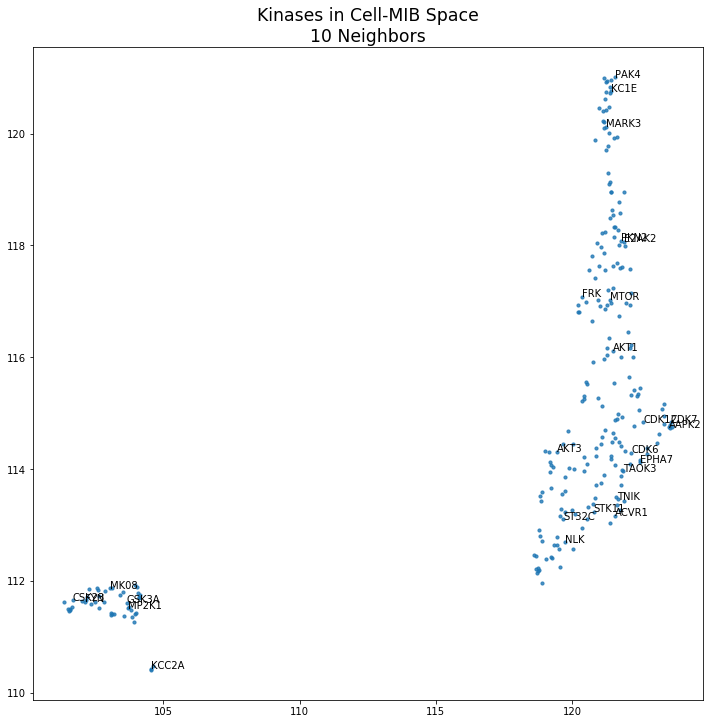

In [8]:
u = UMAP(n_neighbors=10)
coords = u.fit_transform(mib_mibrna)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x=coords[:, 0], y=coords[:, 1], s=10, alpha = .8)
ax.set_title('Kinases in Cell-MIB Space\n10 Neighbors', size='xx-large')

# randomly annotate ~ 25% of points
for i, kinase_name in enumerate(mib_mibrna.index):
    if np.random.randn()>1.2:
        ax.annotate(kinase_name, (coords[i, 0], coords[i, 1]))

plt.show()

In [40]:
louv = pd.read_csv('/Users/isrobson/Github/KIN_ClusteringWithAnnotations/results/weighted/louvain_small_clusters.txt', sep='\t')
louv.set_index('names', inplace=True)
louv.columns = ['cluster_sub']
louv = louv.join(pd.read_csv('/Users/isrobson/Github/KIN_ClusteringWithAnnotations/results/weighted/louvain_clusters.txt', sep='\t').set_index('names'))
louv.columns = ['cluster_sub', 'cluster_super']
louv.head()

,cluster_sub,cluster_super
names,,
MST1R,11,3
YES1,11,3
TYRO3,11,3
FGR,11,3
SRC,11,3


In [10]:
mib_mibrna.index = pd.Series(mib_mibrna.index).apply(lambda x: hgnc_mapper[x])

In [11]:
pd.unique(louv['cluster_super'])

array([3, 2, 4, 7, 6, 5, 8, 1, 9])

### See how the ratio of each subcluster compares to ratios present here

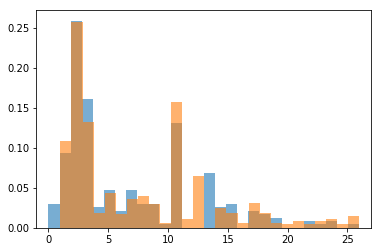

In [12]:
colors_kin = [louv['cluster_sub'][kin] if kin in set(louv.index) else 0 for kin in mib_mibrna.index]
plt.hist(colors_kin, alpha = 0.6, bins=28, density=True)
plt.hist(louv['cluster_sub'], alpha = 0.6, bins=27, density=True)
plt.xlim([-1, 27])
plt.show()

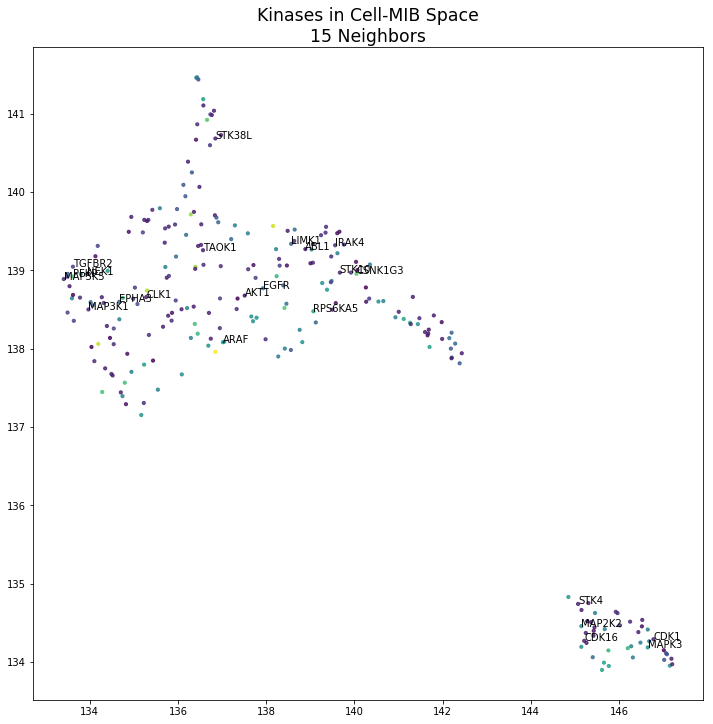

In [13]:
u = UMAP(n_neighbors=15)
coords = u.fit_transform(mib_mibrna)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x=coords[:, 0], y=coords[:, 1], s=10, alpha = .8, c=colors_kin, cmap='viridis')
ax.set_title('Kinases in Cell-MIB Space\n15 Neighbors', size='xx-large')

# randomly annotate ~ 25% of points
for i, kinase_name in enumerate(mib_mibrna.index):
    if np.random.randn()>1.2:
        ax.annotate(kinase_name, (coords[i, 0], coords[i, 1]))

plt.show()

In [14]:
tau_matrix = np.zeros((len(mib_mibrna),len(mib_mibrna)))
tau_p_vals = np.zeros((len(mib_mibrna),len(mib_mibrna)))

ranked_mib = mib_mibrna.apply(stats.rankdata, axis=1)

for i in range(len(mib_mibrna)):
    for j in range(len(mib_mibrna)):
        tau_matrix[i,j], tau_p_vals[i,j] = stats.kendalltau(ranked_mib.iloc[i], ranked_mib.iloc[j])

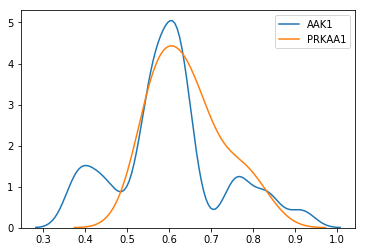

In [15]:
sns.kdeplot(mib_mibrna.iloc[0, :])
sns.kdeplot(mib_mibrna.iloc[1, :])
plt.show()

### Isomap-ability of subclusters

In [16]:
def get_subcluster(target_df, cluster_no, cluster_src):
    '''
    Inputs: 
        target_df -- the dataframe to get data from, index is kinases
        cluster_no -- numberical subcluster to query
        cluster_src -- dataframe with 'cluster_sub' column to identify kinases in a subcluster
    '''
    
    kinases_to_look_for = cluster_src['cluster_sub'][cluster_src['cluster_sub'] == cluster_no].index.tolist()
    target_kinases = np.array(target_df.index.tolist())
    
    # locations to grab
    idx_to_grab = np.where(np.isin(target_kinases, kinases_to_look_for))[0]
    
    return target_df.iloc[idx_to_grab, :]
    

In [19]:
# two is the biggest subcluster
cluster_two = get_subcluster(mib_mibrna, cluster_no=2, cluster_src=louv)
display(cluster_two.shape)
display(cluster_two.head())

(61, 32)

,SUM159.1,SUM159.2,MDA231.1,MDA231.2,SUM229neg.1,SUM229neg.2,HCC1806.1,HCC1806.2,MDA468.1,MDA468.2,...,HCC1954.1,HCC1954.2,MCF7.1,MCF7.2,T47D.1,T47D.2,HCC1428.1,HCC1428.2,ZR751.1,ZR751.2
AAK1,0.563173,0.620986,0.562031,0.426585,0.84158,0.602266,0.624378,0.633291,0.526394,0.469651,...,0.589088,0.559325,0.577343,0.650038,0.609829,0.610864,0.616032,0.384855,0.374681,0.751435
ABL1,0.109939,0.263185,0.436958,0.368187,0.500801,0.166916,0.179506,0.192641,-0.175774,0.272601,...,0.229982,0.226838,0.333653,0.453882,0.377198,0.286458,0.619932,0.241495,0.104607,0.492236
ADK,0.282647,0.185955,0.381269,0.472631,0.560158,0.253723,0.431288,0.483316,0.417111,0.334782,...,0.470169,0.500706,0.418973,0.383116,0.311716,0.341503,0.864675,0.59785,0.46856,0.715339
AURKB,0.136803,0.288155,0.261323,0.391387,0.620295,0.334037,0.291893,0.323154,0.193546,0.164345,...,0.475138,0.498944,0.0488639,0.298459,0.155102,0.144531,0.682715,0.482728,0.173516,0.624389
BMP2K,0.443704,0.504034,0.600773,0.44081,0.628298,0.388643,0.458214,0.447347,0.132528,-3.53095,...,0.500289,0.431646,0.394646,0.497467,0.485459,0.321988,0.55413,0.304679,0.158021,0.615087


In [28]:
# we want the kinases to be columns in the data
X = cluster_two.T.values
display(X.shape)

for i in range(1, 10):
    iso = Isomap(n_components=i)
    coords = iso.fit_transform(X)
    display(i, iso.reconstruction_error())

(32, 61)

1

27.434487887996934

2

23.337522280568077

3

19.07689934810606

4

15.64298165042874

5

14.106513045307468

6

13.146565326847563

7

12.379037130672772

8

11.749730360218189

9

11.433277698042279

In [44]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

for i in range(1, 10):
    lle = LLE(n_components=i)
    coords = lle.fit_transform(X)
    display(i, lle.reconstruction_error_)

1

0.011454393707243164

2

0.03624227627723242

3

0.07431415827265273

4

0.1468884525145318

5

0.24235745079028892

6

0.40268515108353353

7

0.6114955646536957

8

0.9033070815253512

9

1.2330784358234559

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X)
pca.explained_variance_ratio_

array([0.15909274, 0.1293495 , 0.10620339, 0.08579098, 0.07670129])

23.337522280568077

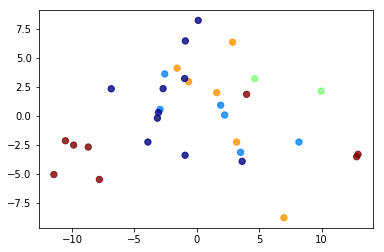

In [45]:
iso = Isomap(n_components=2)
coords = iso.fit_transform(X)
display(iso.reconstruction_error())

x_coords = coords[:, 0]
y_coords = coords[:, 1]
plt.scatter(x_coords, y_coords, c=[type_to_numeric[t] for t in subtypes_all_mibrna[15:]], cmap='jet', alpha=.8, s=40)
plt.show()

In [11]:
type_to_numeric = {y:x for x, y in enumerate(set(subtypes_all_mibrna))}

In [47]:
lle = LLE(n_components=1)
coords = lle.fit_transform(X)
display(lle.reconstruction_error_)

0.011454393707243164

0.03624227627723242

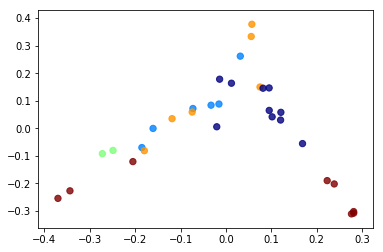

In [54]:
lle = LLE(n_components=2)
coords = lle.fit_transform(X)
display(lle.reconstruction_error_)

x_coords = coords[:, 0]
y_coords = coords[:, 1]
plt.scatter(x_coords, y_coords, c=[type_to_numeric[t] for t in subtypes_all_mibrna[15:]], cmap='jet', alpha=.8, s=40)
plt.show()

### Embed all of the subclusters present with LLE

In [67]:
agg_coords = []
column_list = []
for i in sorted(set(louv['cluster_sub'])):
    lle = LLE(n_components=1)
    sub_dat = get_subcluster(mib_mibrna, cluster_no=i, cluster_src=louv)
    if len(sub_dat > 1):
        lle.fit(sub_dat.T.values)
        print('cluster:', i, lle.reconstruction_error_)
        agg_coords += [lle.embedding_]
        column_list += ['Subclust'+str(i)]
    elif len(sub_dat > 0):
        print('Singleton subclust:', i)
        agg_coords += [sub_dat.T.values]
        column_list += ['Subclust'+str(i)]
    else:
        print('Skipping subclust:', i)
    
print("\n", "Done!")
agg_coords = np.hstack(agg_coords)
print(agg_coords.shape)

cluster: 1 3.453988892256435e-05
cluster: 2 0.011454393707243164
cluster: 3 0.03206197319428762
cluster: 4 1.5737930548668138e-06
cluster: 5 2.0652355521833805e-07
cluster: 6 2.0496607700498226e-15
cluster: 7 1.9349513412707962e-07
cluster: 8 7.097940666477125e-09
cluster: 9 9.951262799475995e-16
cluster: 10 2.965247155842923e-07
cluster: 11 0.0009980639118880867
Skipping subclust: 12
cluster: 13 1.1546022989596559e-05
cluster: 14 8.025937008375208e-16
cluster: 15 2.961142867186022e-05
Skipping subclust: 16
cluster: 17 3.1696725962287593e-15
cluster: 18 6.004801728037371e-08
cluster: 19 3.362510912370315e-07
Skipping subclust: 20
Skipping subclust: 21
cluster: 22 6.247404930763348e-07
cluster: 23 4.629462228197833e-16
cluster: 24 1.1788883949608946e-15
Skipping subclust: 25
cluster: 26 3.3902848800453174e-07

 Done!
(32, 21)


In [69]:
# convert to csv
embed_mat = pd.DataFrame(agg_coords, columns = column_list, index=mib_mibrna.columns)
embed_mat['labels'] = subtypes_all_mibrna[15:]
embed_mat.to_csv('../data/mib-ms/lle_transformed.csv')

In [8]:
embed_mat = pd.read_csv('../data/mib-ms/lle_transformed.csv', index_col=0)
embed_mat.head()

,Subclust1,Subclust2,Subclust3,Subclust4,Subclust5,Subclust6,Subclust7,Subclust8,Subclust9,Subclust10,...,Subclust14,Subclust15,Subclust17,Subclust18,Subclust19,Subclust22,Subclust23,Subclust24,Subclust26,labels
SUM159.1,-0.373203,0.031503,0.531560,-0.086011,0.137058,-0.212815,-0.077045,-0.227933,-0.276750,-0.241245,...,0.047884,-0.113384,0.065041,-0.317398,-0.114168,-0.236983,-0.203481,-0.269729,0.145674,claudin
SUM159.2,-0.294906,-0.072810,0.375418,-0.054971,0.137741,-0.212815,-0.078500,-0.227931,-0.276750,-0.137721,...,0.047884,-0.167118,0.065041,0.197227,-0.115017,-0.110875,-0.203481,-0.269729,0.111681,claudin
MDA231.1,-0.011422,-0.032917,-0.092228,-0.056297,0.137489,-0.212815,-0.081171,0.113492,0.015078,-0.038360,...,-0.210742,0.063391,0.065041,0.041637,0.068800,-0.100082,-0.203481,-0.269729,0.092596,claudin
MDA231.2,-0.278763,-0.015535,0.002897,-0.443227,0.137545,0.131185,-0.081013,-0.255644,0.015078,-0.150643,...,0.047884,0.065483,0.065041,0.039737,-0.066027,-0.137090,-0.203481,-0.269729,0.125680,claudin
SUM229neg.1,-0.034698,-0.185292,0.035497,0.154513,0.187806,0.131185,-0.082954,0.201745,0.015078,0.142099,...,-0.210742,-0.500026,0.136746,0.053574,0.235048,0.238113,-0.203481,0.046265,0.408740,claudin


In [9]:
labels = embed_mat['labels']
embed_mat.drop('labels', axis=1, inplace=True)

[0.25080453 0.17244847 0.11451699]


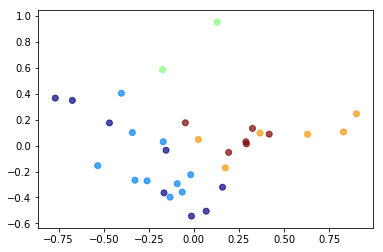

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
coords = pca.fit_transform(embed_mat)
print(pca.explained_variance_ratio_)


plt.scatter(x=coords[:,0], y=coords[:, 1], c=[type_to_numeric[z] for z in labels], alpha=.7, cmap='jet')
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression

In [24]:
clf = LogisticRegression(class_weight='balanced', penalty='l1', solver='saga', multi_class='multinomial')
clf.fit(y=[type_to_numeric[z] for z in labels], X=embed_mat)
clf.score(X=embed_mat, y=[type_to_numeric[z] for z in labels])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.75

In [26]:
from scipy.stats import kruskal

In [28]:
groups = {}
for c in set(labels):
    groups[c] = embed_mat[labels == c]

In [32]:
import itertools as it
for g1, g2 in it.combinations(groups.keys(), r=2):
    print(g1,g2, kruskal(groups[g1], groups[g2]))

luminal her2 KruskalResult(statistic=24573.969298245614, pvalue=0.0)
luminal basal/her2 KruskalResult(statistic=13624.363636363636, pvalue=0.0)
luminal claudin KruskalResult(statistic=16609.742857142857, pvalue=0.0)
luminal basal KruskalResult(statistic=16715.44523809524, pvalue=0.0)
her2 basal/her2 KruskalResult(statistic=16574.423076923078, pvalue=0.0)
her2 claudin KruskalResult(statistic=17827.975000000002, pvalue=0.0)
her2 basal KruskalResult(statistic=17816.46029411765, pvalue=0.0)
basal/her2 claudin KruskalResult(statistic=13618.444444444445, pvalue=0.0)
basal/her2 basal KruskalResult(statistic=14293.444444444445, pvalue=0.0)
claudin basal KruskalResult(statistic=12818.66666666667, pvalue=0.0)


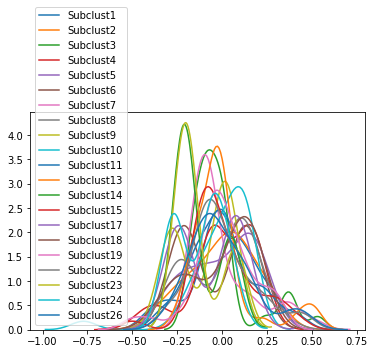

In [71]:
for i in range(embed_mat.shape[1]):
    sns.kdeplot(embed_mat.iloc[:, i], )
plt.show()

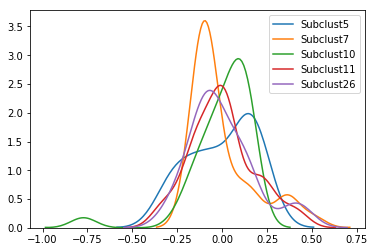

In [72]:
for c in [ "Subclust5", "Subclust7", "Subclust10", "Subclust11", "Subclust26"]:
    sns.kdeplot(embed_mat[c])
plt.show()

[0.14047636 0.10292116]


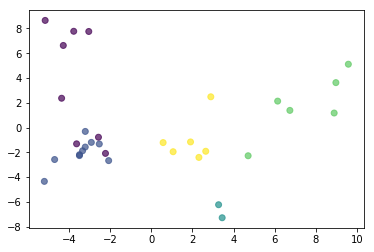

In [74]:
pca = PCA(n_components=2)
coords = pca.fit_transform(mib_mibrna.T)
print(pca.explained_variance_ratio_)

plt.scatter(x=coords[:, 0], y=coords[:, 1], c=[type_to_numeric[z] for z in labels], alpha = 0.7)
plt.show()

0.04176954890539694


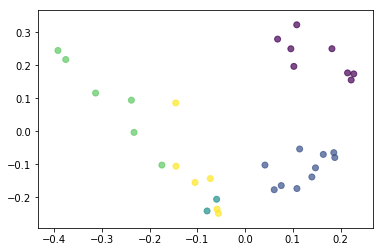

In [77]:
from sklearn.manifold import LocallyLinearEmbedding as LLE
lle = LLE(n_components=2)
coords = lle.fit_transform(mib_mibrna.T)
print(lle.reconstruction_error_)

plt.scatter(x=coords[:, 0], y=coords[:, 1], c=[type_to_numeric[z] for z in labels], alpha = 0.7)
plt.show()

[0.42949857 0.19360951 0.16293002 0.13746324 0.07649866]


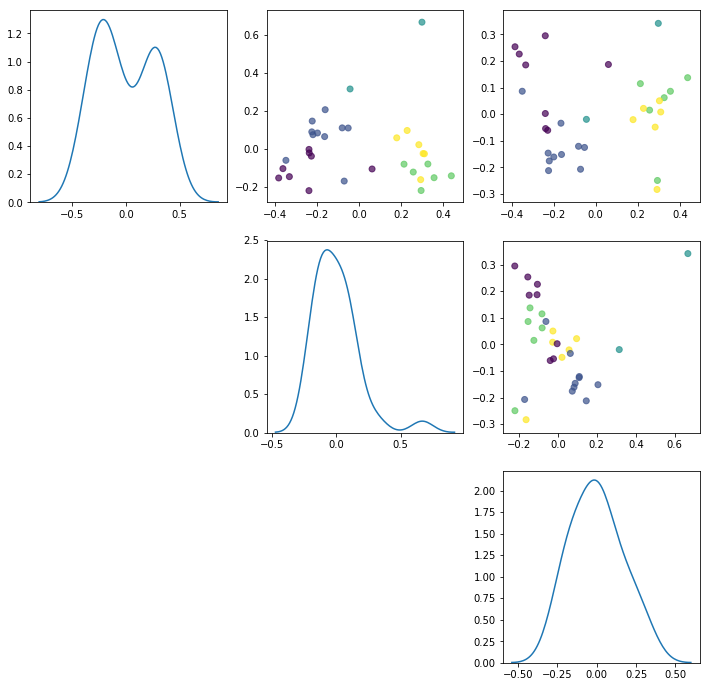

In [81]:
reduced_mat = embed_mat[[ "Subclust5", "Subclust7", "Subclust10", "Subclust11", "Subclust26"]]
pca = PCA(n_components=5)
coords = pca.fit_transform(reduced_mat)
print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=3)

for i in range(3):
    for j in range(3):
        if i > j:
            axes[i][j].set_visible(False)
        elif i == j:
            sns.kdeplot(coords[:, i], ax=axes[i][j])
        else:
            axes[i][j].scatter(x=coords[:, i], y=coords[:, j], c=[type_to_numeric[z] for z in labels], alpha = 0.7)

plt.show()

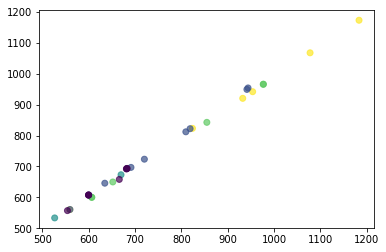

In [69]:
from umap import UMAP
u = UMAP(n_components=2, n_neighbors=9, min_dist=.01)
coords = u.fit_transform(reduced_mat)

plt.scatter(x=coords[:, 0], y=coords[:, 1], c=[type_to_numeric[z] for z in labels], alpha = 0.7)
plt.show()

In [53]:
louv_subset = louv[louv['cluster_sub'].isin([5,7,10,11,26])]
present_louv_subset = louv_subset[louv_subset.index.isin(mib_mibrna.index)]
present_louv_subset.shape

(35, 2)

### Graphical Lasso stuff (old)


In [175]:
from sklearn.covariance import GraphicalLasso

glasso = GraphicalLasso(alpha=.1)
glasso.fit(mib_mibrna)

GraphicalLasso(alpha=0.1, assume_centered=False, enet_tol=0.0001,
        max_iter=100, mode='cd', tol=0.0001, verbose=False)

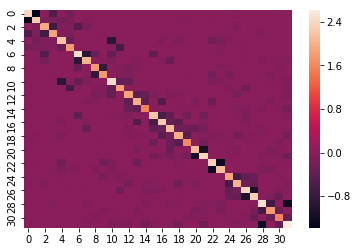

In [176]:
sns.heatmap(glasso.precision_)
plt.show()

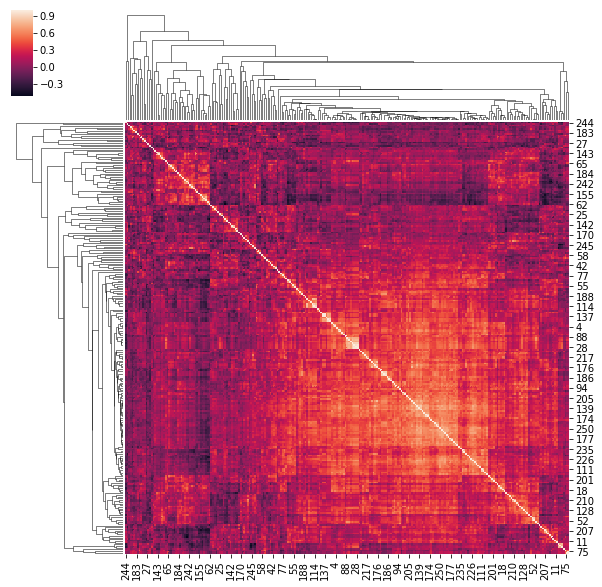

In [153]:
#fig, ax = plt.subplots(figsize = (12,12))
sns.clustermap(tau_matrix, metric='cosine')
plt.show()

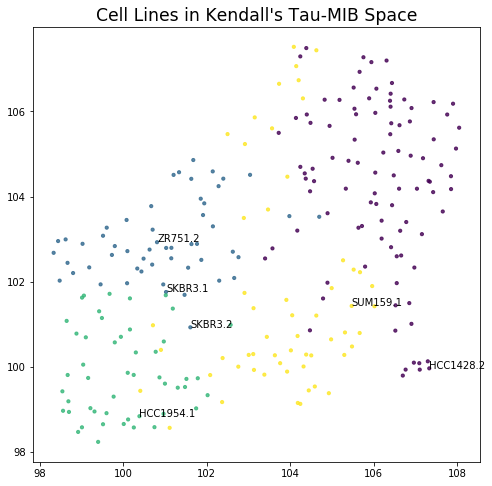

In [334]:
u_cor = UMAP(metric='cosine', n_neighbors=10, min_dist=.5)
cor_coords = u_cor.fit_transform(1-tau_matrix)

km = KMeans(n_clusters=4)
preds = km.fit_predict(1-tau_matrix)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=cor_coords[:, 0], y=cor_coords[:, 1], s=10, alpha = .8, c = preds)
ax.set_title('Cell Lines in Kendall\'s Tau-MIB Space', size='xx-large')

# randomly annotate ~ 30% of cell lines 
for i, cell_name in enumerate(mib_mibrna.columns):
    if np.random.randn()>1:
        ax.annotate(cell_name, (cor_coords[i, 0], cor_coords[i, 1]))

plt.show()

In [ ]:
u_cor = UMAP(metric='cosine', n_neighbors=10)
cor_coords = u_cor.fit_transform(1-tau_matrix)

km = KMeans(n_clusters=4)
preds = km.fit_predict(1-tau_matrix)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=cor_coords[:, 0], y=cor_coords[:, 1], s=10, alpha = .8, c = preds)
ax.set_title('Cell Lines in Kendall\'s Tau-MIB Space', size='xx-large')

# randomly annotate ~ 30% of cell lines
for i, cell_name in enumerate(mib_mibrna.columns):
    if np.random.randn()>1:
        ax.annotate(cell_name, (cor_coords[i, 0], cor_coords[i, 1]))

plt.show()

In [ ]:
sns.clustermap(tau_matrix*(tau_p_vals>.001))
plt.show()

In [191]:
tau_p_vals

array([[7.60078151e-36, 3.82539266e-04, 1.22547598e-02, ...,
        6.87554020e-01, 3.54116475e-03, 1.40940668e-01],
       [3.82539266e-04, 7.60078151e-36, 4.81278010e-08, ...,
        4.11283919e-01, 2.51940287e-04, 2.90030617e-04],
       [1.22547598e-02, 4.81278010e-08, 7.60078151e-36, ...,
        9.10377904e-01, 3.33350411e-04, 2.13465482e-02],
       ...,
       [6.87554020e-01, 4.11283919e-01, 9.10377904e-01, ...,
        7.60078151e-36, 4.11283919e-01, 2.65532096e-01],
       [3.54116475e-03, 2.51940287e-04, 3.33350411e-04, ...,
        4.11283919e-01, 7.60078151e-36, 1.69402084e-01],
       [1.40940668e-01, 2.90030617e-04, 2.13465482e-02, ...,
        2.65532096e-01, 1.69402084e-01, 7.60078151e-36]])

In [198]:
tau_p_vals[np.triu_indices_from(tau_p_vals, k=1)]

array([3.82539266e-04, 1.22547598e-02, 6.07248777e-03, ...,
       4.11283919e-01, 2.65532096e-01, 1.69402084e-01])

In [208]:
ranks = np.zeros_like(tau_p_vals)
ranks[np.triu_indices_from(ranks, k=1)] = stats.rankdata(tau_p_vals[np.triu_indices_from(tau_p_vals, k=1)], method='max')#.reshape(tau_p_vals.shape)
ranks[np.tril_indices_from(ranks, k=-1)] = ranks.T[np.tril_indices_from(ranks, k=-1)]
ranks

array([[    0.,  3586.,  8167., ..., 26802.,  6156., 15214.],
       [ 3586.,     0.,   327., ..., 21761.,  3195.,  3321.],
       [ 8167.,   327.,     0., ..., 30630.,  3455.,  9279.],
       ...,
       [26802., 21761., 30630., ...,     0., 21761., 18618.],
       [ 6156.,  3195.,  3455., ..., 21761.,     0., 16060.],
       [15214.,  3321.,  9279., ..., 18618., 16060.,     0.]])

/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


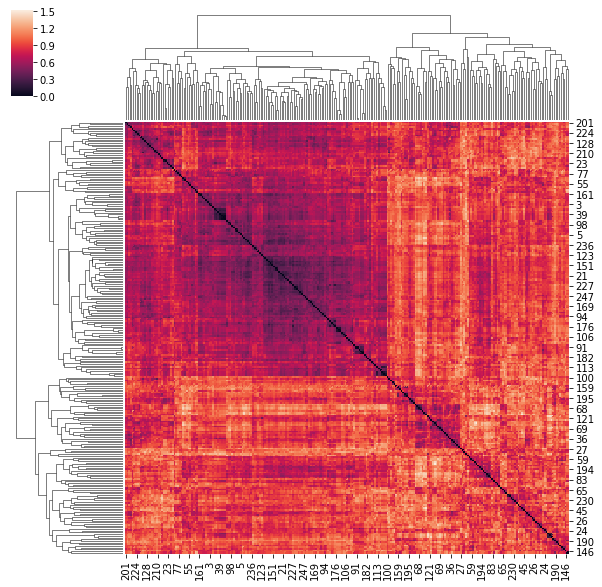

In [216]:
# this is the kendall's tau correlation distance 
sns.clustermap(1-tau_matrix)
plt.show()

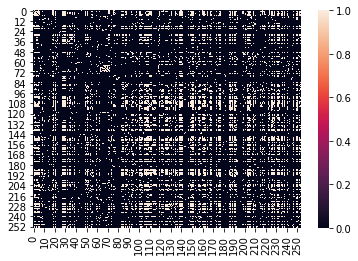

In [228]:
sns.heatmap(tau_p_vals < ranks/(len(mib_mibrna)*(len(mib_mibrna) - 1)/2)*.01)
fdr_mask = tau_p_vals < ranks/(len(mib_mibrna)*(len(mib_mibrna) - 1)/2)*.01
plt.show()

/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


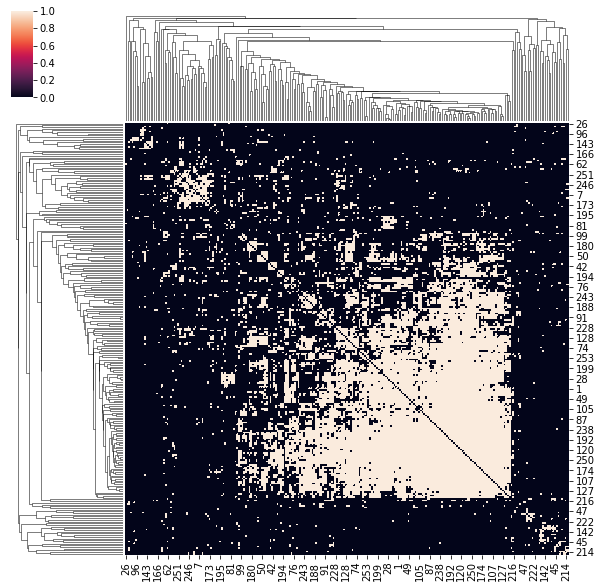

In [221]:
fdr_mask = tau_p_vals < ranks/(len(mib_mibrna)*(len(mib_mibrna) - 1)/2)*.05
sns.clustermap(fdr_mask, metric='cosine')
plt.show()

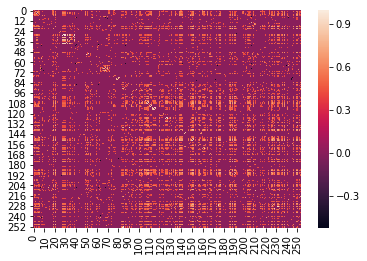

In [234]:
adj_matrix = fdr_mask * tau_matrix
sns.heatmap(adj_matrix)
plt.show()

In [317]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=4)
preds = clust.fit_predict(2-adj_matrix)


In [271]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=10)
coords = iso.fit_transform(mib_mibrna)

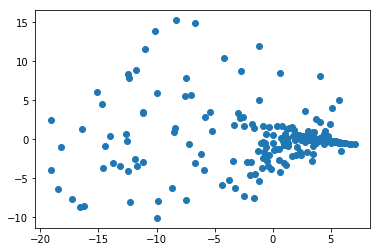

In [272]:
plt.scatter(coords[:, 0], coords[:, 1])
plt.show()

In [264]:
from sklearn.cluster import SpectralBiclustering
sb = SpectralBiclustering()
sb.fit(mib_mibrna)

SpectralBiclustering(init='k-means++', method='bistochastic',
           mini_batch=False, n_best=3, n_clusters=3, n_components=6,
           n_init=10, n_jobs=None, n_svd_vecs=None, random_state=None,
           svd_method='randomized')

In [275]:
from scipy.cluster.hierarchy import linkage

In [300]:
preds

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 3, 1, 2, 0, 2, 2, 2, 3, 3,
       1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 3, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 1,
       0, 2, 0, 3, 1, 1, 0, 3, 3, 3, 0, 0, 0, 0, 0, 1, 0, 2, 3, 3, 3, 0,
       2, 0, 0, 2, 3, 0, 1, 1, 3, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 3, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 3, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 3, 3, 3, 1, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 2, 1, 0, 3, 3, 2, 3, 0, 0, 3, 2, 0, 1, 3, 0, 3, 0, 0, 2,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 1], dtype=int32)

In [245]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(affinity='precomputed')
preds = ap.fit_predict(adj_matrix)


In [303]:
metrics.adjusted_rand_score(preds, colors_kin)

0.001987221314590601

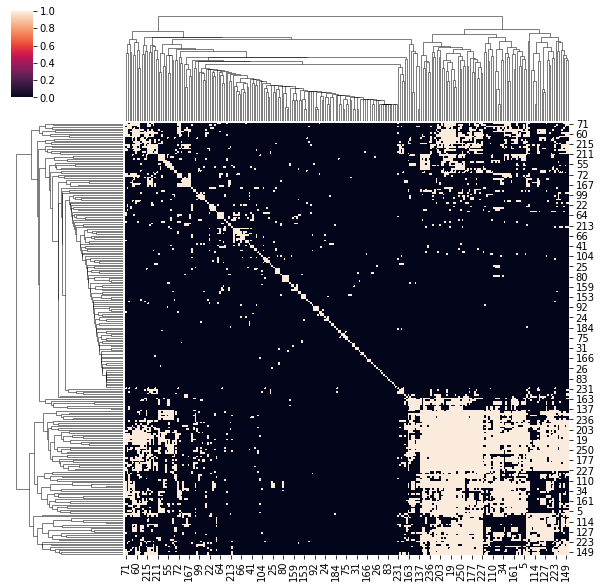

In [189]:
sns.clustermap(tau_p_vals<0.001)
plt.show()

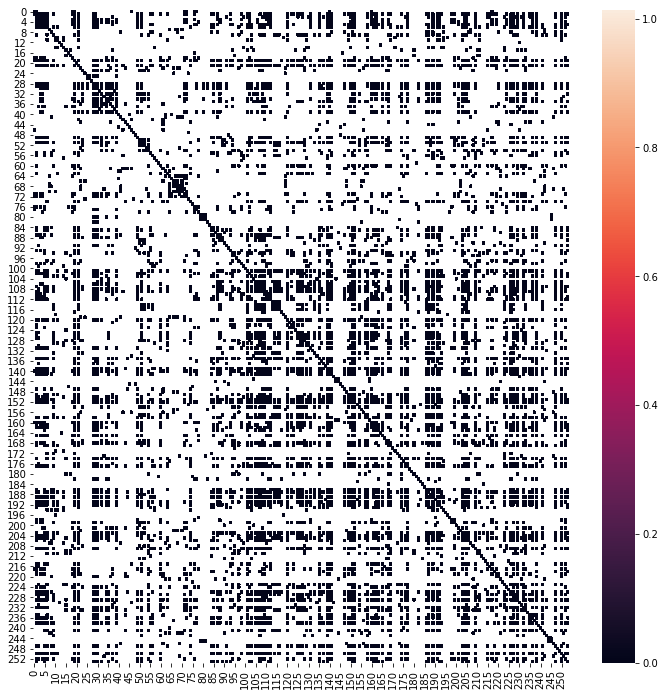

In [135]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(tau_p_vals, mask = tau_p_vals>0.001)
plt.show()

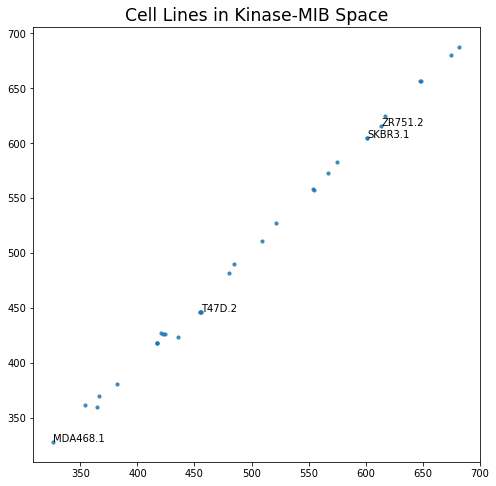

In [77]:
u_cell = UMAP(n_neighbors=5)
cell_coords = u_cell.fit_transform(mib_mibrna.T)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=cell_coords[:, 0], y=cell_coords[:, 1], s=10, alpha = .8)
ax.set_title('Cell Lines in Kinase-MIB Space', size='xx-large')

# randomly annotate ~ 30% of cell lines
for i, cell_name in enumerate(mib_mibrna.columns):
    if np.random.randn()>1:
        ax.annotate(cell_name, (cell_coords[i, 0], cell_coords[i, 1]))

plt.show()

In [ ]:
'''bt474_lapatinib = pd.read_excel('../data/mib-ms/BT474-300nM Lapatinib Pooled stats.xlsx', sheet_name='Sheet1')
duncan.head()'''